# Phylogenetics of H2A

### Plan:
1. Analyse statistics of H2A (count variants among species)
2. Building phylogentic tree for all sequences:

   2.1 Create MSA for all sequences
   
   2.2 Make PHYLIP file from MSA
   
   2.3 Create tree using PhyML
   
   2.4 Reroot the tree
   
   2.5 Analyse tree
   
3. Building phylogentic tree within species
4. Analyse results

In [128]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
from curated_set_services import CuratedSet

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ete3 import NCBITaxa

# from Bio import SeqIO, Entrez, Phylo, SearchIO
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord
# from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo

from pynucl.hist_features import hist_shf4seq, hist_features, hist_shade_features
from pytexshade import ipyshade, shade

## Statistics of H2A (count variants among species)

In [122]:
#Load data from histones.csv
cs = CuratedSet()
df = cs.data[cs.data['type']=='H2A'].drop(columns=['doublet']).fillna('')
df.shape

(204, 15)

In [123]:
df['taxonomy_id'] = pd.to_numeric(df['taxonomy_id']).fillna(0).astype('int64').replace(0, '')

In [124]:
names = ['Metazoa', 'Fungi',
         'Rhodophyta', 'Viridiplantae',
         'Rhizaria', 'Alveolata', 'Stramenopiles']
ncbi = NCBITaxa()
taxids_dict = ncbi.get_name_translator(names)
taxids = [taxids_dict[name][0] for name in names]

highlvl_taxids = []
for taxid in df['taxonomy_id']:
    if taxid == '':
        highlvl_taxids.append('Not identified')
        continue
    try:
        lineage = ncbi.get_lineage(taxid)
    except ValueError as e:
#         print(e)
        highlvl_taxids.append('')
        continue
    intersection = set(taxids).intersection(set(lineage))
    if len(intersection)==0:
        highlvl_taxids.append('Not identified')
    elif len(intersection)==1:
        highlvl_taxids.append(list(ncbi.get_taxid_translator([intersection.pop()]).values())[0])
    else:
        print('Something get wrong!!!')
        break

df['highlvl_taxonomy'] = highlvl_taxids
df.head()

,accession,type,variant_group,variant,gi,ncbi_gene_id,hgnc_gene_name,taxonomy_id,organism,phylum,class,taxonomy_group,info,references,sequence,highlvl_taxonomy
XP_010685819.1,XP_010685819.1,H2A,cH2A,cH2A,731349093,,,3555,Beta vulgaris subsp. vulgaris,Streptophyta,Magnoliopsida,,,,MDSTAGGKAKKGAGGRKGGGPKKKPVSRSVKAGLQFPVGRIGRYLK...,Viridiplantae
NP_001190852.1,NP_001190852.1,H2A,cH2A,cH2A,334186954,,,3702,Arabidopsis thaliana,Streptophyta,Magnoliopsida,,,,MAGRGKQLGSGAAKKSTSRSSKAGLQFPVGRIARFLKAGKYAERVG...,Viridiplantae
NP_175517.1,NP_175517.1,H2A,cH2A,cH2A,15223708,,,3702,Arabidopsis thaliana,Streptophyta,Magnoliopsida,,,,MAGRGKTLGSGSAKKATTRSSKAGLQFPVGRIARFLKKGKYAERVG...,Viridiplantae
NP_188703.1,NP_188703.1,H2A,cH2A,cH2A,15232330,,,3702,Arabidopsis thaliana,Streptophyta,Magnoliopsida,,,,MAGRGKTLGSGVAKKSTSRSSKAGLQFPVGRIARFLKNGKYATRVG...,Viridiplantae
NP_200275.1,NP_200275.1,H2A,cH2A,cH2A,15239697,,,3702,Arabidopsis thaliana,Streptophyta,Magnoliopsida,,,,MAGRGKTLGSGGAKKATSRSSKAGLQFPVGRIARFLKAGKYAERVG...,Viridiplantae


In [125]:
df.describe()

,accession,type,variant_group,variant,gi,ncbi_gene_id,hgnc_gene_name,taxonomy_id,organism,phylum,class,taxonomy_group,info,references,sequence,highlvl_taxonomy
count,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204
unique,204,1,13,38,139,28,28,50,65,14,17,2,2,10,179,5
top,NP_001190852.1,H2A,cH2A,cH2A,,,,9606,Homo sapiens,Chordata,Mammalia,,,,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,Metazoa
freq,1,204,53,36,66,171,171,33,33,138,126,171,201,139,9,131


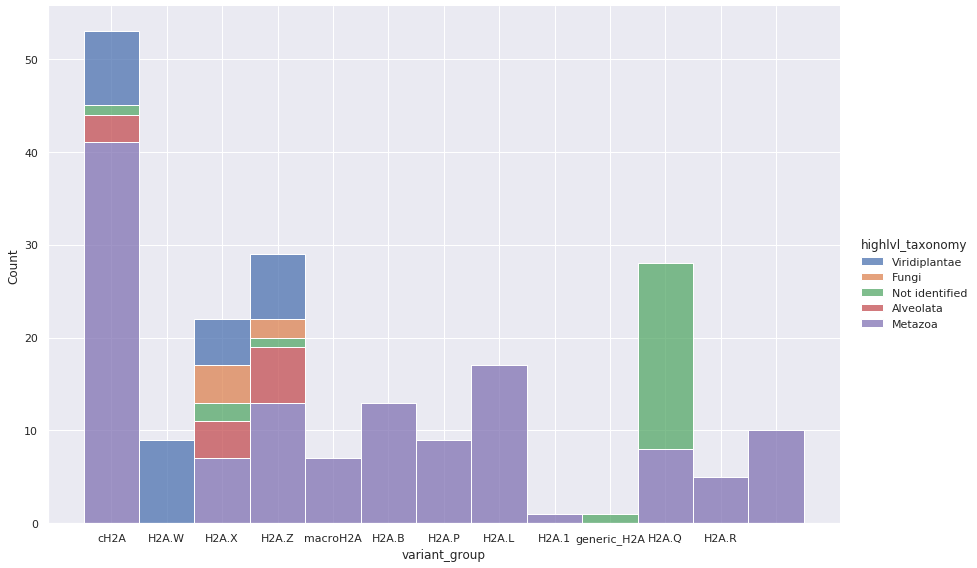

In [126]:
ax = sns.displot(data=df, x="variant_group", hue="highlvl_taxonomy", multiple="stack", height=8, aspect=1.5)

## Building phylogentic tree for all sequences:

### Create MSA for all sequences

In [131]:
def cons_features(msa):
#     features_shf4seq = hist_shade_features(hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'), hist_type='H2A'),
#                                            feature_types=['loop','helix','sheet','frameblock'])
    features_shf4seq = hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))
    features = []
    for f in features_shf4seq:
        f_new = f
        f_new['seqref'] = 'consensus'
        features.append(f_new)
    return features

In [133]:
msa = cs.muscle_aln(df['accession'])
msa

<<class 'Bio.Align.MultipleSeqAlignment'> instance (204 records of length 484, SingleLetterAlphabet()) at 7fdd6440d048>

In [141]:
# with open('H2A_msa.fasta', 'w') as f:
#     f.write(msa.format("fasta"))
with open('H2A_msa.phy', 'w') as f:
    f.write(format(msa,"phylip-relaxed"))

In [ ]:
ipyshade.shadedmsa(msa,shading_modes=['similar'], ruler=True, logo=True, splitN=20, features=cons_features(msa))